In [51]:
# Dependencies and Setup
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind
import  statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
# File to load
Melbourne_refined_listings_cleaned = Path ("Outputs/Melbourne_refined_listings_cleaned.csv")

# Read Melbourne_refined_listings_cleaned data
airbnb_data = pd.read_csv(Melbourne_refined_listings_cleaned)
airbnb_data.head()


,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,572431386115618941,446636199,2022-02-24,"St Kilda, Australia",within an hour,95%,99%,f,t,t,...,4.0,4.6,4.43,4.37,3.97,8,0,4,4,1.21
1,727686708237430703,382295537,2020-12-30,"Melbourne, Australia",within a few hours,89%,57%,f,t,t,...,4.2,4.2,4.20,4.20,4.20,3,0,3,0,0.81
2,1051913801382467131,22860147,2014-10-22,"Melbourne, Australia",within an hour,100%,99%,f,t,t,...,5.0,5.0,5.00,4.50,4.00,105,105,0,0,0.98
3,1106234039745058155,16365362,2014-06-04,"Melbourne, Australia",within an hour,100%,100%,f,t,t,...,5.0,5.0,5.00,5.00,5.00,1,0,1,0,1.00
4,1053974246558615906,551937839,2023-12-21,"Point Cook, Australia",within an hour,97%,94%,f,t,t,...,4.0,3.5,4.00,4.00,5.00,7,7,0,0,2.00


In [52]:
#Convert host_since to datetime format if it's not already

airbnb_data['host_since'] = pd.to_datetime(airbnb_data['host_since'])


In [53]:
# Calculate Host experience in years
airbnb_data['host_experience_years'] = (datetime.now() - airbnb_data['host_since']).dt.days / 365

In [54]:
# Change "price` to numeric by stripping the '$' and converting to float
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)


In [55]:
# Aggregate data by host
host_data = airbnb_data.groupby('host_id').agg({
    'host_experience_years': 'max',  # Use max for years of experience
    'id': 'count',                   # Count number of listings
    'price': 'mean',                 # Mean price
    'number_of_reviews': 'sum',      # Total reviews
    'review_scores_rating': 'mean'   # Average rating
}).rename(columns={
    'id': 'num_listings',
    'number_of_reviews': 'total_reviews',
    'review_scores_rating': 'avg_rating'
}).reset_index()  # Reset index for cleanliness
host_data

,host_id,host_experience_years,num_listings,price,total_reviews,avg_rating
0,9082,15.356164,2,105.0,28,4.89
1,15565,15.197260,1,300.0,1,4.00
2,18785,15.134247,1,138.0,2,5.00
3,20588,15.095890,1,132.0,54,4.98
4,21345,15.082192,1,115.0,31,4.77
...,...,...,...,...,...,...
5130,561797490,0.402740,1,368.0,3,5.00
5131,561798630,0.402740,1,157.0,5,5.00
5132,562103428,0.400000,2,75.0,2,5.00
5133,562487587,0.391781,1,312.0,1,1.00


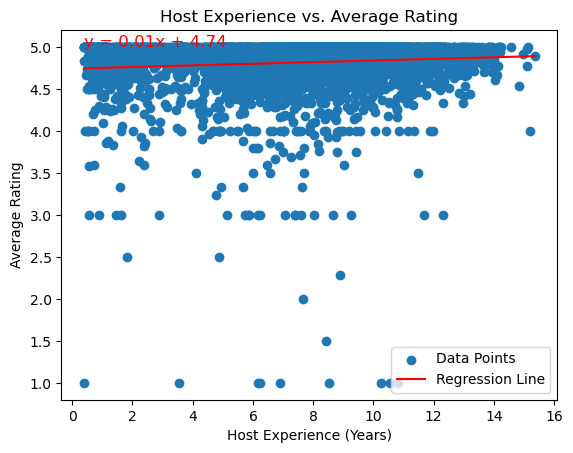

In [56]:
#Scatter plot: Host experience vs. Average rating

# Define Variables
X = host_data['host_experience_years']
Y = host_data['avg_rating']

# Calculate Regression Line
coefficients = np.polyfit(X, Y, 1)
poly = np.poly1d(coefficients)
regression_line = poly(X)

# Scatter Plot
plt.scatter(X, Y, label='Data Points')

# Regression Line
plt.plot(X, regression_line, color='red', label='Regression Line')

# Add equation to the plot
equation_text = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}'
plt.text(min(X), max(Y), equation_text, fontsize=12, color='red')

# Add labels and title
plt.xlabel('Host Experience (Years)')
plt.ylabel('Average Rating')
plt.title('Host Experience vs. Average Rating')
plt.legend()

# Save the plot to a file
output_path = 'plots/Scatter_showing_experience_vs_Ratings.png'
plt.savefig(output_path)
#Show plot
plt.show()

The above presentation show that there is a slight positive correlation between average rating and host experience. 

Correlation: 0.10, P-value: 0.00


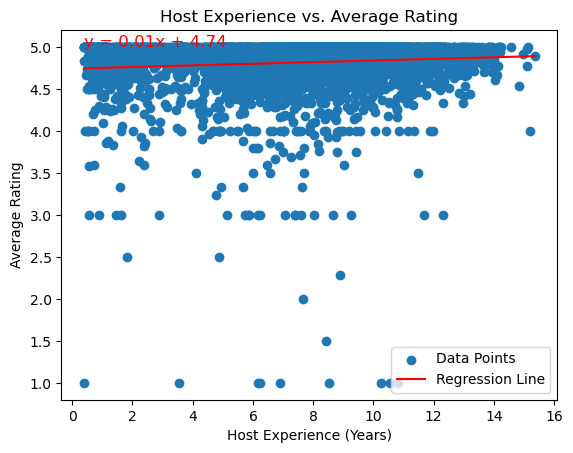

In [57]:
# Hypothesis Testing and statistical analysis
# Correlation analysis 

correlation, p_value = pearsonr(host_data['host_experience_years'], host_data['avg_rating'])
print(f'Correlation: {correlation:.2f}, P-value: {p_value:.2f}')

# Display the correlation coefficient and p-value on the plot
plt.scatter(X, Y, label='Data Points')

# Regression Line
plt.plot(X, regression_line, color='red', label='Regression Line')

# Add equation and correlation to the plot
equation_text = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}'
correlation_text = f'Correlation: {correlation:.2f}, P-value: {p_value:.2f}'
plt.text(min(X), max(Y), equation_text, fontsize=12, color='red')
#plt.text(min(X), max(Y) - 0.1, correlation_text, fontsize=12, color='blue')

# Add labels and title
plt.xlabel('Host Experience (Years)')
plt.ylabel('Average Rating')
plt.title('Host Experience vs. Average Rating')
plt.legend()

# Show plot with correlation information
plt.show()

The above presentation show that there is a weak positive correlation between average rating and host experience. The P Value of 3.888496808457316e-12 is exceedingly small, much smaller than 0.05, indicating that the correlation is statistically significant. Therefore, while there is some statistically significant positive correlation between average rating and host experience, the actual influence that host experience has on average rating is almost negligible.In practical terms, even though we have found a statistically significant correlation, the weak strength suggests that host experience may not have a strong impact on average ratings. Other factors might play a more crucial role in determining average ratings and should be explored.

In [58]:
#Calculate Top ten experience host
top_experienced_host = host_data.sort_values ("host_experience_years",ascending =False)
top_experienced_host.head(10)


,host_id,host_experience_years,num_listings,price,total_reviews,avg_rating
0,9082,15.356164,2,105.0,28,4.89
1,15565,15.197260,1,300.0,1,4.00
2,18785,15.134247,1,138.0,2,5.00
3,20588,15.095890,1,132.0,54,4.98
4,21345,15.082192,1,115.0,31,4.77
5,26687,14.978082,1,158.0,775,4.92
6,38901,14.821918,1,51.0,185,4.53
7,64240,14.567123,1,119.0,10,5.00
8,112497,14.224658,1,98.0,6,5.00
9,114878,14.208219,1,90.0,25,5.00


In [59]:
#Calculate Bottom ten experience host
top_experienced_host = host_data.sort_values ("host_experience_years")
top_experienced_host.head(10)

,host_id,host_experience_years,num_listings,price,total_reviews,avg_rating
5134,562614562,0.389041,1,136.0,1,5.000
5133,562487587,0.391781,1,312.0,1,1.000
5132,562103428,0.400000,2,75.0,2,5.000
5131,561798630,0.402740,1,157.0,5,5.000
5130,561797490,0.402740,1,368.0,3,5.000
5129,561780891,0.405479,1,211.0,1,5.000
5128,561627820,0.405479,2,162.0,4,4.835
5127,561267616,0.413699,1,77.0,3,5.000
5126,561111312,0.416438,1,296.0,1,4.000
5125,560626153,0.421918,1,90.0,4,5.000


T-statistic: -6.91, P-value: 0.00


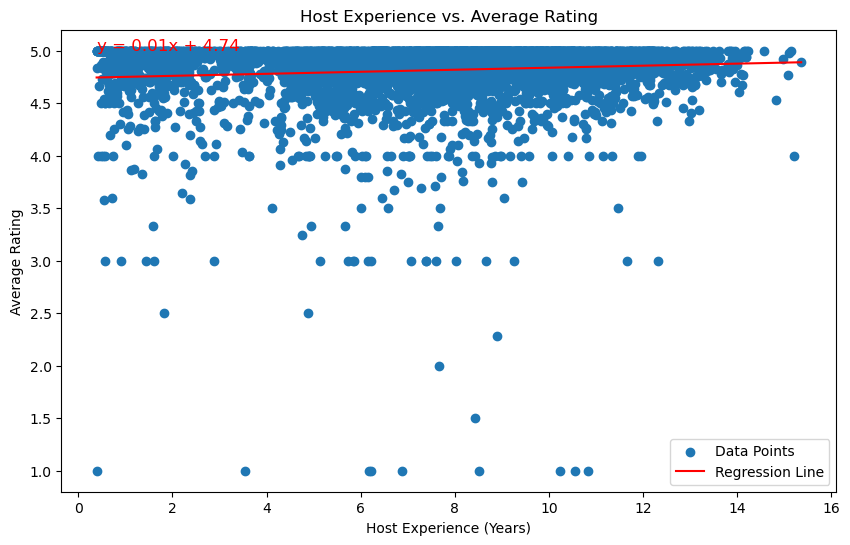

T-test Results: T-statistic: -6.91, P-value: 0.00


In [60]:
# Split the data into two groups based on host experience (e.g., <= 7.5 years and > 7.5 years)
group1 = host_data[host_data['host_experience_years'] <= 7.5]['avg_rating']
group2 = host_data[host_data['host_experience_years'] > 7.5]['avg_rating']

# Perform a t-test
t_stat, p_value = ttest_ind(group1, group2)
print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.2f}')

# Define Variables for correlation analysis and regression line
X = host_data['host_experience_years']
Y = host_data['avg_rating']

# Calculate Regression Line
coefficients = np.polyfit(X, Y, 1)
poly = np.poly1d(coefficients)
regression_line = poly(X)

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Data Points')

# Regression Line
plt.plot(X, regression_line, color='red', label='Regression Line')

# Add equation and correlation to the plot
equation_text = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}'
plt.text(min(X), max(Y), equation_text, fontsize=12, color='red')

# Perform Correlation Analysis
correlation, p_value_corr = pearsonr(X, Y)
correlation_text = f'Correlation: {correlation:.2f}, P-value: {p_value_corr:.2f}'
#plt.text(min(X), max(Y) - 0.1, correlation_text, fontsize=12, color='blue')

# Add labels and title
plt.xlabel('Host Experience (Years)')
plt.ylabel('Average Rating')
plt.title('Host Experience vs. Average Rating')
plt.legend()

# Show plot
plt.savefig('Scatter_Plot_with_Regression_and_Correlation.png')
plt.show()

# Output the results of the t-test
print(f'T-test Results: T-statistic: {t_stat:.2f}, P-value: {p_value:.2f}')

There is a substantial difference between the average ratings of the two groups (group1 and group2).
The negative sign suggests that the average rating of the first group (host experience ≤ 7.5 years) is substantially lower than that of the second group (host experience > 7.5 years).

The P-value indicates the probability of observing a test statistic as extreme as, or more extreme than, the observed one if the null hypothesis (that the two group means are equal) is true. With a P-value reported as 0.00 (p < 0.001):

The result is highly statistically significant.
There is strong evidence to reject the null hypothesis, which states that the means of the two groups are the same.
These results suggest that there is a statistically significant difference between the average ratings of hosts with ≤ 7.5 years of experience and those with > 7.5 years of experience. Specifically:

Hosts with more than 7.5 years of experience tend to have higher average ratings compared to those with 7.5 years or less experience.
Given the statistical significance (very low P-value), this difference is unlikely to be due to random chance.


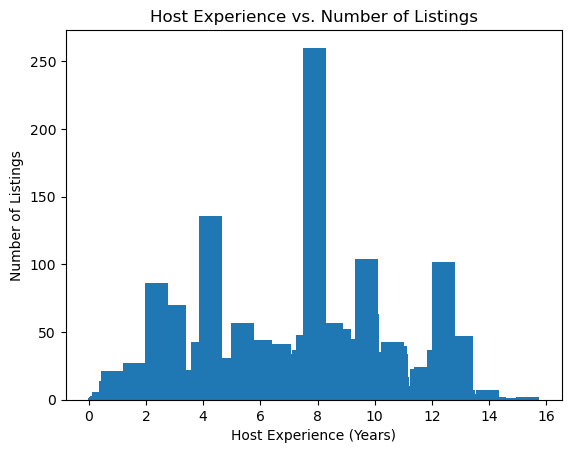

In [61]:
# Bar Chart showing number of listings per avarage rating
plt.bar(host_data['host_experience_years'], host_data['num_listings'])
plt.title('Host Experience vs. Number of Listings')
plt.xlabel('Host Experience (Years)')
plt.ylabel('Number of Listings')

# Save the plot to a file
output_path = 'plots/experience_vs_listings.png'
plt.savefig(output_path)

# Show the plot
plt.show()

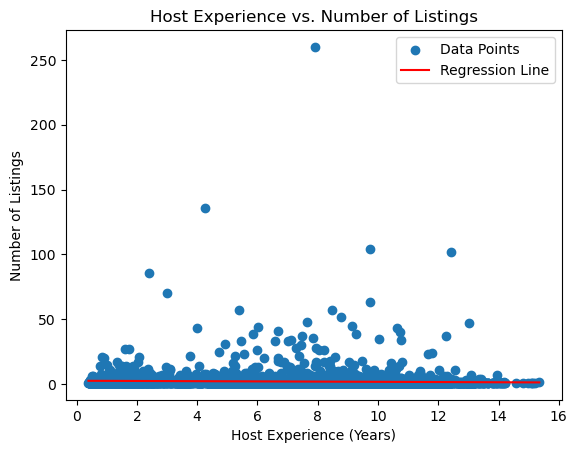

In [62]:
#Scatter plot: Host experience vs. Number of Listings

# Define Variables
X = host_data['host_experience_years']
Y = host_data ['num_listings']

#Calculate Regression line
coefficients = np.polyfit(X,Y, 1)
poly = np.poly1d(coefficients)
regression_line = poly (X)

#Scatter Plot
plt.scatter(X, Y, label='Data Points')

#Regression Line
plt.plot (X, regression_line, color = 'red', label = 'Regression Line')

#Add labels and tittle
plt.xlabel ('Host Experience (Years)')
plt.ylabel ('Number of Listings')
plt.title ('Host Experience vs. Number of Listings')
plt.legend()

# Save the plot to a file
output_path = 'plots/Scatter_showing_experience_vs_listings.png'
plt.savefig(output_path)
#Show plot
plt.show()

The above Scatter shows that there is no relationship between host experience vs. number of listings

In [63]:
#Calculate correlation between 'price' and 'host_experience'
# Convert 'price' to numeric by stripping the '$' and converting to float
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)
correlation = airbnb_data['price'].corr(airbnb_data['host_experience_years'])

# Print correlation result
print(f"Correlation between price and host experince years: {correlation:.2f}")

Correlation between price and host experince years: 0.03


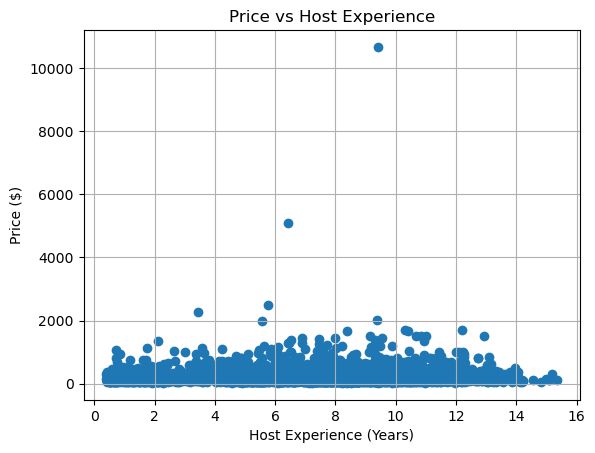

In [64]:
# Plot the relationship

plt.scatter(host_data['host_experience_years'], host_data['price'])
plt.title('Price vs Host Experience')
plt.xlabel('Host Experience (Years)')
plt.ylabel('Price ($)')
plt.grid(True)

# Save the plot to a file
output_path = 'plots/Scatter_Price_vs_Host_experience.png'
plt.savefig(output_path)
plt.show()

In [65]:
#Identify Outliers using IQR Method

Q1 = host_data['price'].quantile(0.25)
Q3 = host_data['price'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = host_data[(host_data['price'] < (Q1 - 1.5 * IQR)) | (host_data['price'] > (Q3 + 1.5 * IQR))]
print(outliers)

# Remove outliers
host_data_clean = host_data[~((host_data['price'] < (Q1 - 1.5 * IQR)) | (host_data['price'] > (Q3 + 1.5 * IQR)))]

        host_id  host_experience_years  num_listings   price  total_reviews  \
72       581252              13.169863             1   623.0            111   
84       677155              13.095890             1   839.0              6   
88       730414              13.057534             1   529.0              5   
89       747841              13.043836             1   602.0            128   
105      907869              12.945205             1  1500.0              1   
...         ...                    ...           ...     ...            ...   
4997  529628655               0.934247             1   542.0             14   
5019  535914326               0.838356             1   957.0              4   
5041  541588108               0.742466             1   693.0             14   
5043  542239609               0.728767             1   800.0              1   
5049  543515812               0.704110             1  1057.0              1   

      avg_rating  
72          4.76  
84          4

Correlation: 0.00, P-value: 0.77


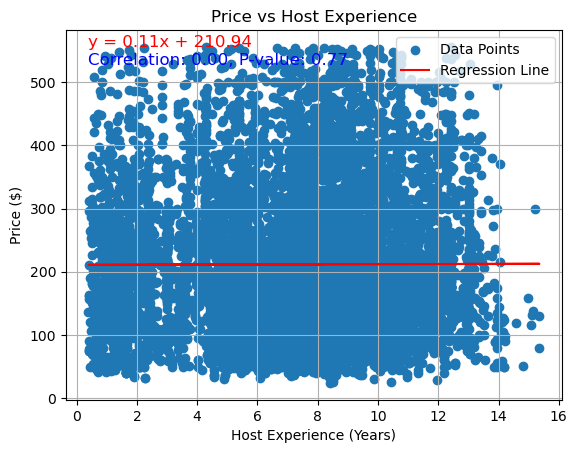

In [69]:
# Plot the relationship
X = airbnb_data_clean['host_experience_years'].values.reshape(-1, 1)
Y = airbnb_data_clean['price'].values

# Compute the Pearson correlation coefficient
correlation, p_value = pearsonr(airbnb_data_clean['host_experience_years'], airbnb_data_clean['price'])
print(f'Correlation: {correlation:.2f}, P-value: {p_value:.2f}')

# Fit a linear regression model
model = LinearRegression()
model.fit(X, Y)

# Get predictions (regression line)
regression_line = model.predict(X)

# Plotting
plt.scatter(airbnb_data_clean['host_experience_years'], airbnb_data_clean['price'], label='Data Points')

# Add regression line to plot
plt.plot(airbnb_data_clean['host_experience_years'], regression_line, color='red', label='Regression Line')

# Add equation and correlation to the plot
coefficients = model.coef_
intercept = model.intercept_
equation_text = f'y = {coefficients[0]:.2f}x + {intercept:.2f}'
correlation_text = f'Correlation: {correlation:.2f}, P-value: {p_value:.2f}'
plt.text(min(airbnb_data_clean['host_experience_years']), max(airbnb_data_clean['price']), equation_text, fontsize=12, color='red')
plt.text(min(airbnb_data_clean['host_experience_years']), max(airbnb_data_clean['price']) * 0.95, correlation_text, fontsize=12, color='blue')

# Final plot 
plt.title('Price vs Host Experience')
plt.xlabel('Host Experience (Years)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()

# Save the plot to a file
output_path = 'plots/Scatter_Price_vs_Host_experience_2.png'
plt.savefig(output_path)
plt.show()

The above presentation show suggest that there is no correlation between price and host experience. Other variables may have a more significant impact on the price than host experience